<ipython-input-14-a41fa14a806e>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  regression_data['total_bedrooms'].fillna(regression_data['total_bedrooms'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/g

Bayesian Predictions Keys:
dict_keys(['Bayesian (α₁=1e-06, α₂=1e-06)', 'Bayesian (α₁=1e-05, α₂=1e-05)', 'Bayesian (α₁=0.0001, α₂=0.0001)'])
Gaussian Predictions Keys:
dict_keys(['Gaussian (α=0.001)', 'Gaussian (α=0.01)', 'Gaussian (α=0.1)'])


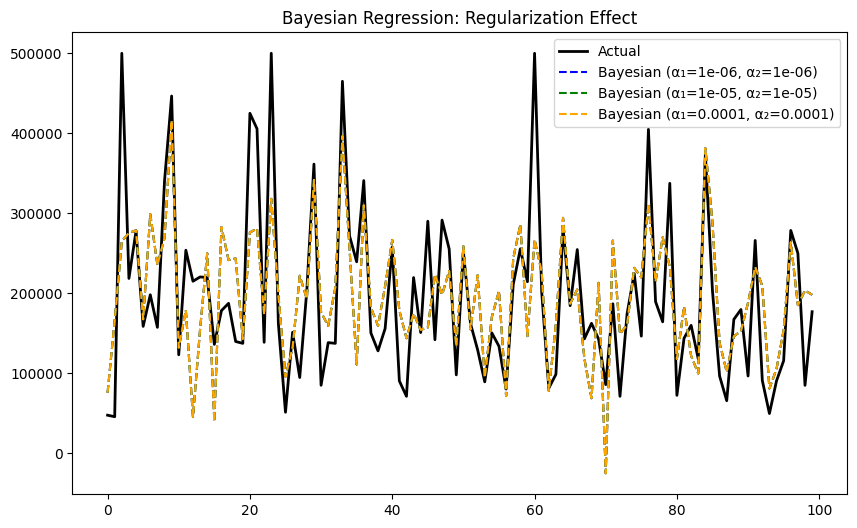

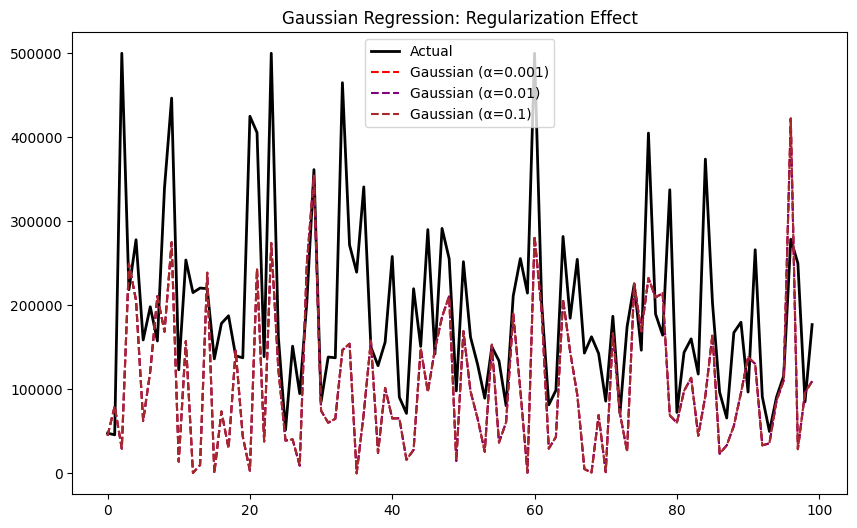

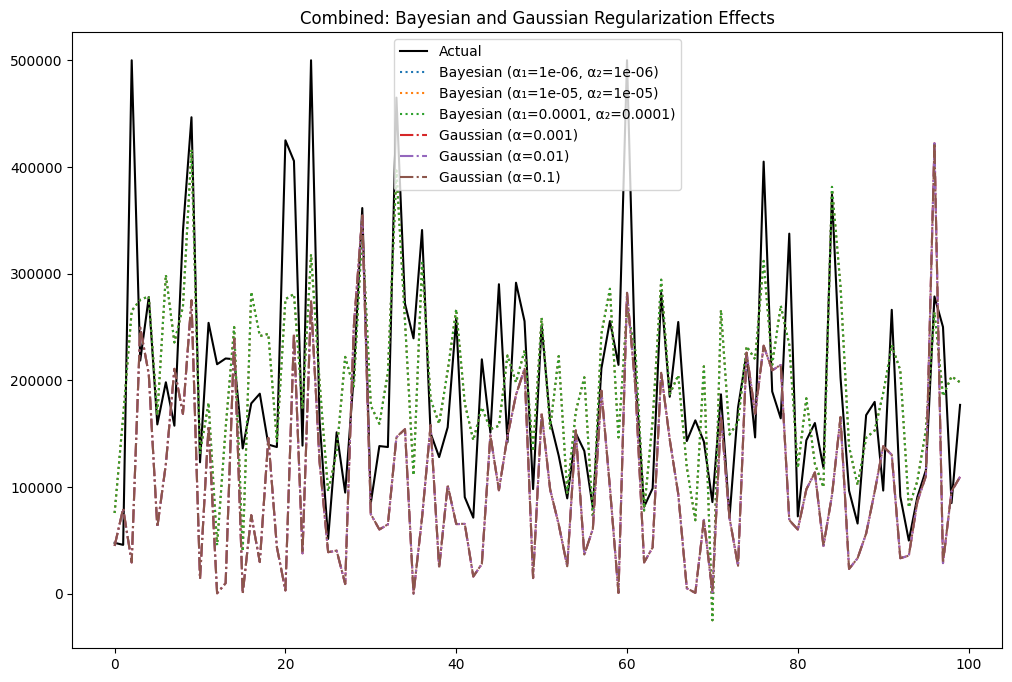


Bayesian (α₁=1e-06, α₂=1e-06) Performance:
RMSE: 71079.28
R²: 0.61

Bayesian (α₁=1e-05, α₂=1e-05) Performance:
RMSE: 71079.28
R²: 0.61

Bayesian (α₁=0.0001, α₂=0.0001) Performance:
RMSE: 71079.28
R²: 0.61

Gaussian (α=0.001) Performance:
RMSE: 134797.93
R²: -0.39

Gaussian (α=0.01) Performance:
RMSE: 134789.48
R²: -0.39

Gaussian (α=0.1) Performance:
RMSE: 134705.40
R²: -0.38

Ridge (No Regularization) Performance:
RMSE: 71084.13
R²: 0.61

Ridge (With Regularization) Performance:
RMSE: 71080.77
R²: 0.61


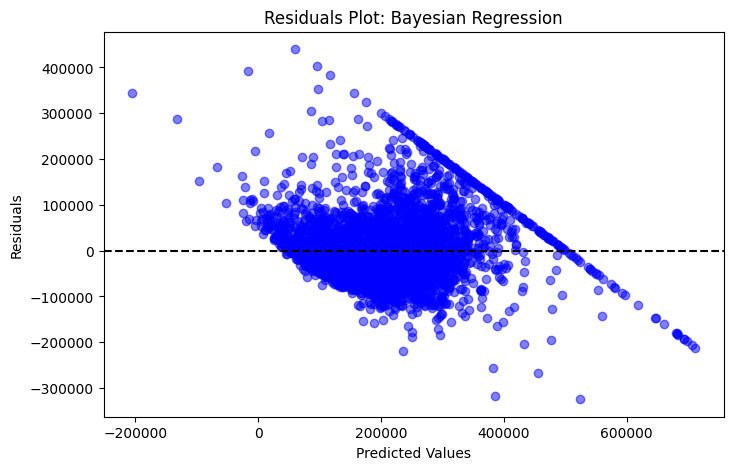

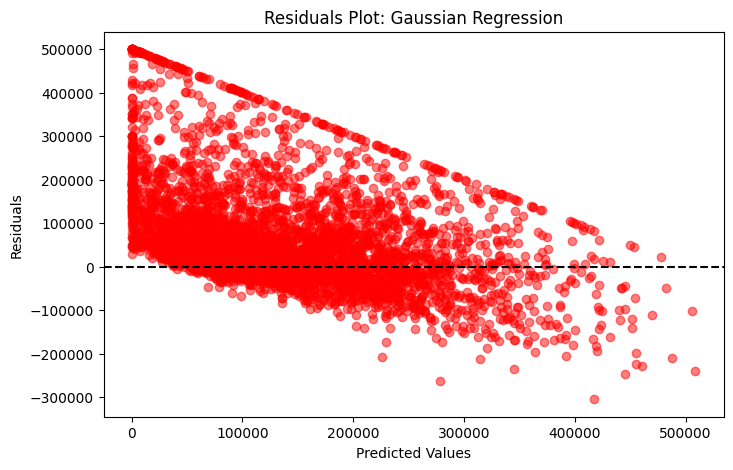

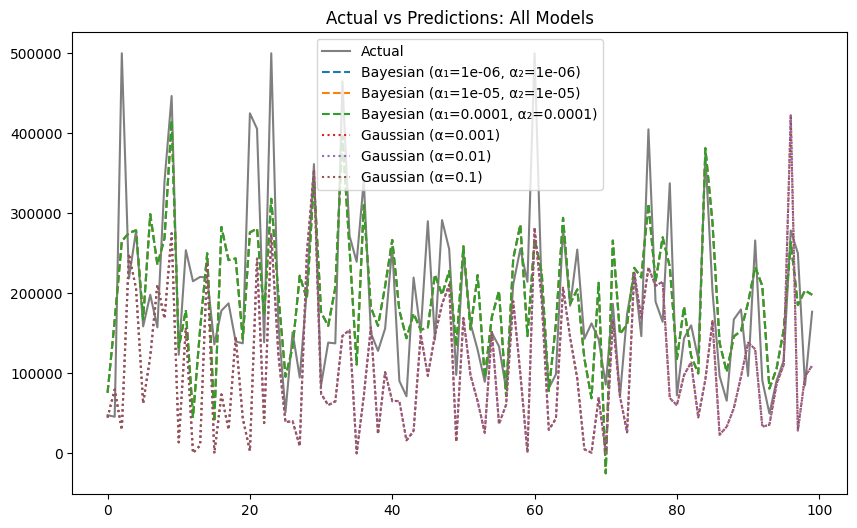

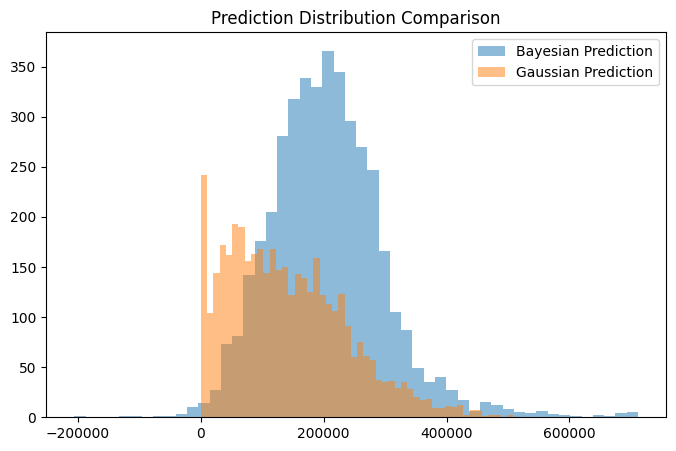

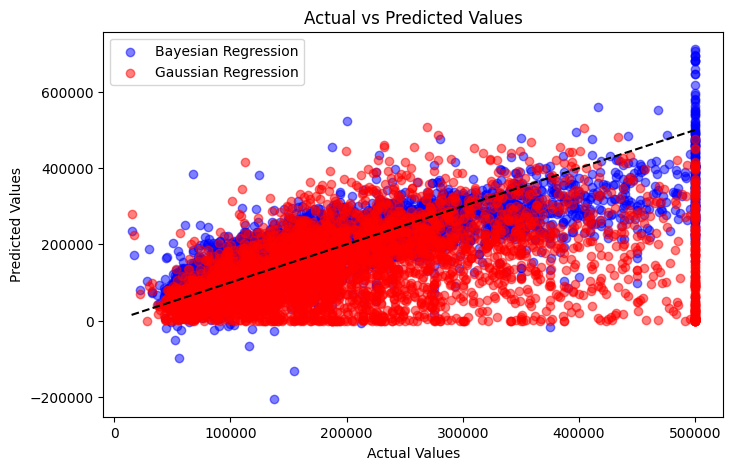

In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, BayesianRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load and preprocess the dataset
regression_data = pd.read_csv('/content/housing.csv')  # Update the path if necessary
regression_data['total_bedrooms'].fillna(regression_data['total_bedrooms'].mean(), inplace=True)

X = regression_data.drop(['median_house_value', 'ocean_proximity'], axis=1)
y = regression_data['median_house_value']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Ridge Regression: With and Without Regularization
ridge_no_reg = Ridge(alpha=0)  # No regularization
ridge_with_reg = Ridge(alpha=1.0)  # With regularization
ridge_no_reg.fit(X_train, y_train)
ridge_with_reg.fit(X_train, y_train)

y_pred_no_reg = ridge_no_reg.predict(X_test)
y_pred_with_reg = ridge_with_reg.predict(X_test)

# Bayesian Regression with varying regularization
bayesian_preds = {}
for alpha_1, alpha_2 in [(1e-6, 1e-6), (1e-5, 1e-5), (1e-4, 1e-4)]:
    model = BayesianRidge(alpha_1=alpha_1, alpha_2=alpha_2)
    model.fit(X_train, y_train)
    bayesian_preds[f"Bayesian (α₁={alpha_1}, α₂={alpha_2})"] = model.predict(X_test)

# Gaussian Process Regression with varying regularization
gaussian_preds = {}
for alpha in [1e-3, 1e-2, 1e-1]:
    kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2))
    model = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=10)
    model.fit(X_train[:500], y_train[:500])  # Limiting data size for computational efficiency
    gaussian_preds[f"Gaussian (α={alpha})"] = model.predict(X_test)

# Print the available keys in bayesian_preds and gaussian_preds to verify
print("Bayesian Predictions Keys:")
print(bayesian_preds.keys())

print("Gaussian Predictions Keys:")
print(gaussian_preds.keys())

# Corrected Visualization for Bayesian Regression Regularization
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:100], label="Actual", color="black", linewidth=2)
colors = ['blue', 'green', 'orange']  # Distinct colors for each alpha value
for idx, (alpha_1, alpha_2) in enumerate([(1e-6, 1e-6), (1e-5, 1e-5), (1e-4, 1e-4)]):
    preds = bayesian_preds[f"Bayesian (α₁={alpha_1}, α₂={alpha_2})"]
    plt.plot(preds[:100], label=f"Bayesian (α₁={alpha_1}, α₂={alpha_2})", linestyle="dashed", color=colors[idx])
plt.title("Bayesian Regression: Regularization Effect")
plt.legend()
plt.show()

# Corrected Visualization for Gaussian Process Regression Regularization
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:100], label="Actual", color="black", linewidth=2)
colors = ['red', 'purple', 'brown']  # Distinct colors for each alpha value
for idx, alpha in enumerate([1e-3, 1e-2, 1e-1]):
    preds = gaussian_preds[f"Gaussian (α={alpha})"]
    plt.plot(preds[:100], label=f"Gaussian (α={alpha})", linestyle="dashed", color=colors[idx])
plt.title("Gaussian Regression: Regularization Effect")
plt.legend()
plt.show()

# Combined Visualization
plt.figure(figsize=(12, 8))
plt.plot(y_test.values[:100], label="Actual", color="black")
for name, preds in bayesian_preds.items():
    plt.plot(preds[:100], label=name, linestyle="dotted")
for name, preds in gaussian_preds.items():
    plt.plot(preds[:100], label=name, linestyle="dashdot")
plt.title("Combined: Bayesian and Gaussian Regularization Effects")
plt.legend()
plt.show()

# Performance Evaluation
models_regression = {
    **bayesian_preds,
    **gaussian_preds,
    "Ridge (No Regularization)": y_pred_no_reg,
    "Ridge (With Regularization)": y_pred_with_reg
}

for name, preds in models_regression.items():
    rmse = np.sqrt(mean_squared_error(y_test, preds))  # Compute RMSE
    r2 = r2_score(y_test, preds)  # Compute R²
    print(f"\n{name} Performance:")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")

# Residuals Plot for Bayesian Regression (use the exact key from the printed output)
selected_bayesian_key = 'Bayesian (α₁=1e-06, α₂=1e-06)'  # Corrected key based on printed output
residuals_bayesian = y_test - bayesian_preds[selected_bayesian_key]  # Use the correct key
plt.figure(figsize=(8, 5))
plt.scatter(bayesian_preds[selected_bayesian_key], residuals_bayesian, alpha=0.5, color='blue')
plt.axhline(y=0, color='black', linestyle='dashed')
plt.title("Residuals Plot: Bayesian Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

# Residuals Plot for Gaussian Regression (use the exact key from the printed output)
selected_gaussian_key = 'Gaussian (α=0.001)'  # Corrected key based on printed output
residuals_gaussian = y_test - gaussian_preds[selected_gaussian_key]  # Use the correct key
plt.figure(figsize=(8, 5))
plt.scatter(gaussian_preds[selected_gaussian_key], residuals_gaussian, alpha=0.5, color='red')
plt.axhline(y=0, color='black', linestyle='dashed')
plt.title("Residuals Plot: Gaussian Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()


# Combined: Actual vs All Predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:100], label="Actual", color="black", alpha=0.5)
for name, preds in bayesian_preds.items():
    plt.plot(preds[:100], label=name, linestyle="dashed")
for name, preds in gaussian_preds.items():
    plt.plot(preds[:100], label=name, linestyle="dotted")
plt.title("Actual vs Predictions: All Models")
plt.legend()
plt.show()

# Select a correct key based on the printed output
selected_bayesian_key = 'Bayesian (α₁=1e-06, α₂=1e-06)'  # Use an actual key from the print output

# Prediction Distribution
plt.figure(figsize=(8, 5))
# Use the correct key here from bayesian_preds dictionary
plt.hist(bayesian_preds[selected_bayesian_key], bins=50, alpha=0.5, label="Bayesian Prediction")
plt.hist(gaussian_preds['Gaussian (α=0.001)'], bins=50, alpha=0.5, label="Gaussian Prediction")  # Correct Gaussian key
plt.legend()
plt.title("Prediction Distribution Comparison")
plt.show()

# Select an exact key from the printed output, ensure it matches the key in the code
selected_bayesian_key = 'Bayesian (α₁=1e-06, α₂=1e-06)'  # Correct key based on printed output

# Actual vs Predicted (Scatter Plot) with correct keys
plt.figure(figsize=(8, 5))
# Use the exact key from bayesian_preds dictionary
plt.scatter(y_test, bayesian_preds[selected_bayesian_key], color="blue", alpha=0.5, label="Bayesian Regression")
plt.scatter(y_test, gaussian_preds['Gaussian (α=0.001)'], color="red", alpha=0.5, label="Gaussian Regression")  # Correct Gaussian key
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="black", linestyle="dashed")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.show()

